#### Import Libraries

In [95]:
from collections import Counter
import re
import math
import random
import timeit
import sys
import numpy as np
import random
import hashlib
import matplotlib.pyplot as plt

#### Lossy Counting

In [96]:
class LossyCounting:
    def __init__(self, epsilon, f):
        self.epsilon = epsilon
        self.f = f
        self.window = int(1 / self.epsilon)
        self.current_bucket = 1
        self.bucket_ids = {}
        self.count = Counter()

    def element_counting(self, data):
        i = 0
        for element in data:
            #element = int(element.rstrip('\n'))
            i += 1
            if element in self.count:
                self.count[element] += 1
            else:
                self.count[element] = 1
                self.bucket_ids[element] = self.current_bucket - 1
            if i % self.window ==0:
                for key in list(self.count.keys()):
                    if self.count[key] == 1:
                        del self.count[key]
                        del self.bucket_ids[key]
                    else:
                        self.count[key] -= 1	
                self.current_bucket += 1

    def return_counting(self, N):
        for key in list(self.count.keys()):
            if self.count[key] < (self.f - self.epsilon) * N:
                del self.count[key]
        return self.count

# lc_test = LossyCounting(0.01,0.3)
# elements = ['apple', 'banana', 'apple', 'orange', 'banana', 'banana', 'apple', 'apple', 'banana']

# lc_test.element_counting(elements)

# print("heavy hitters and its counts：", lc_test.return_counting(len(elements)))


#### Sticky Sampling

In [97]:
class StickySampling:
    def __init__(self, f, epsilon, delta):
        '''
        ref: https://www.inf.ed.ac.uk/teaching/courses/exc/slides/dataStreams02.pdf 
        
        support threshold: s (0, 1)
        erro parameter: epsilon (0, 1)
        probability of failure: delta (0, 1)
        '''
        self.f = f
        self.epsilon = epsilon
        self.delta = delta
        self.window = int (1/self.epsilon * math.log10(1/(self.f * self.delta)))
        self.r = 1  # Sampling rate r grows in proportion to window size
        self.count = Counter()

    def element_counting(self, data):
        i = 0
        for element in data:
            i += 1
            if element in self.count:
                self.count[element] += 1                # Go through elements if counter exists,increase it
            else:
                if random.random() < (1 / self.r):  
                    self.count[element] = 1             # If not, create one with probability 1/r
            
            if i % self.window == 0:                    # Window boundary
                self.r *= 2                             # r growing at the same rate as window size
                self.window *= 2

                for key in list(self.count.keys()):
                    while (random.random() < 0.5):      # Repeatedly toss an unbiased coin until the coin toss is successful
                        if self.count[key] == 1:
                            del self.count[key]         #  If  becomes count becomes 0 during this process, we delete the entry
                            break
                        else:
                            self.count[key] -= 1	    # diminishing count by one for every unsuccessful toss


    def return_counting(self, N):
        for key in list(self.count.keys()):
            if self.count[key] < (self.f - self.epsilon) * N:
                del self.count[key]
        return self.count
            

#### Count-Min Sketch

In [98]:
class CountMinSketch:
    def __init__(self, width, depth):
        '''
        width: size of hash tables (K)
        depth: amount of hash tables (N)
        talbe: total number of buckets with K*N np array
        func : params of a, b, p for N hash function ( a * x + b) % p
        '''
        self.width = width
        self.depth = depth
        self.table = np.zeros((depth, width), dtype=int)
        self.func = np.zeros((depth, 3), dtype=int)
        self.generate_hash_fun()

    # Reference: https://stackoverflow.com/questions/567222/simple-prime-number-generator-in-python
    def is_prime(self,p):
        for i in range(2, int(math.sqrt(p)) + 1):
            if p % i == 0:
                return False
        return True

    def generate_prime(self):
        '''
        generate a prime that is bigger than the size of hash tables(K)
        '''
        c = random.randint(1,100)
        prime = self.width * c + 1
        while not self.is_prime(prime):
            prime += 1
        return prime

    def generate_hash_fun(self):
        for i in range (self.depth):
            p = self.generate_prime()
            a = random.randint(1,p-1)
            b = random.randint(1,p-1)
            self.func[i] = [a, b, p]

    def hash_fun(self, x, a, b, p):
        ans = (a * x + b) % p
        return ans

    def add(self, input):
        #Reference: https://stackoverflow.com/questions/12492137/python-sum-of-ascii-values-of-all-characters-in-a-string
        #x = sum(ord(c) for c in input) # convert string into integer
        #https://stackoverflow.com/questions/16008670/how-to-hash-a-string-into-8-digits
        x =int(hashlib.sha1(input.encode("utf-8")).hexdigest(), 16) % (10 ** 8)
        for d in range (self.depth):
            a = self.func[d][0]
            b = self.func[d][1]
            p = self.func[d][2]
            index = self.hash_fun(x,a,b,p) % self.width
            self.table[d, index] += 1

    def count(self, input):
        min_count = float('inf')
        x =int(hashlib.sha1(input.encode("utf-8")).hexdigest(), 16) % (10 ** 8)
        for d in range (self.depth):
            a = self.func[d][0]
            b = self.func[d][1]
            p = self.func[d][2]
            min_count = min(min_count, self.table[d, self.hash_fun(x,a,b,p) % self.width])
        return min_count

#### Misra Gries

In [99]:
def misra_gries(data, f):
	count = Counter()
	k = 1/f
	for d in data:
		# d = int(d.rstrip('\n'))
		if len(count)< k-1 or d in count:
			count[d] += 1
		else:
			for key in list(count.keys()):
				count[key] -= 1
				if count[key] == 0:
					del count[key]
	return count

#### Brute Force

In [100]:
def brute_force(data):
	count = Counter()
	for d in data:
		# d = int(d.rstrip('\n'))
		count[d] += 1
	return count

#### Compare and Analysis

In [101]:
file_path = 'Pride_and_Prejudice.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    book_text = file.read()
#Reference: https://www.guru99.com/python-regular-expressions-complete-tutorial.html
words = re.findall(r'\b\w+\b', book_text.lower())

no_common = 8
words_to_count = ['the', 'to', 'of', 'and', 'her', 'i', 'a', 'in']
cm_result = {}



# Setting Lossy Counting
lc_start = timeit.default_timer()
lc_Pride_and_Prejudice = LossyCounting(0.0001,0.015)
lc_Pride_and_Prejudice.element_counting(words)
lc_result = lc_Pride_and_Prejudice.return_counting(len(words))
lc_stop = timeit.default_timer()
lc_time = lc_stop - lc_start
lc_space = sys.getsizeof(lc_result)

# Setting Sticky Sampling
ss_start = timeit.default_timer()
ss_Pride_and_Prejudice = StickySampling(0.015, 0.0001, 0.00001)
ss_Pride_and_Prejudice.element_counting(words)
ss_result = ss_Pride_and_Prejudice.return_counting(len(words))
ss_stop = timeit.default_timer()
ss_time = ss_stop - ss_start
ss_space = sys.getsizeof(ss_result)

# Setting Misra_Gries
mg_start = timeit.default_timer()
mg_result = misra_gries(words, 0.015)
mg_stop = timeit.default_timer()
mg_time = mg_stop - mg_start
mg_space = sys.getsizeof(mg_result)

# Setting Count-Min Sketch
cm_start = timeit.default_timer()
cms = CountMinSketch(100, 2)
for element in words:
    cms.add(element)
cm_stop = timeit.default_timer()
cm_time = cm_stop - cm_start
cm_space = sys.getsizeof(cms) + cms.table.nbytes + cms.func.nbytes
for word in words_to_count:
    estimated_count = cms.count(word)
    cm_result[word] = estimated_count


# Setting Brute Force
bt_start = timeit.default_timer()
bt_result = brute_force(words)
bt_stop = timeit.default_timer()
bt_time = bt_stop - bt_start
bt_space = sys.getsizeof(bt_result)


print(len(words))
print("Lossy Counting Result: ", lc_result)
print("Sticky Sampling Result: ", ss_result)
print("Misra Gries Result: ", mg_result.most_common(no_common))
print("CountMin Sketch Result: ", cm_result)
print("Brute Force Result: ", bt_result.most_common(no_common))
print("-------------------")
print("Lossy Counting Time: ", lc_time)
print("Sticky Sampling Time: ", ss_time)
print("Misra Gries Time: ", mg_time)
print("CountMin Sketch Time: ", cm_time)
print("Brute Force Time: ", bt_time)
print("-------------------")
print("Lossy Counting Space: ", lc_space)
print("Sticky Sampling Space: ", ss_space)
print("Misra Gries Space: ", mg_space)
print("CountMin Sketch Space: ", cm_space)
print("Brute Force Space: ", bt_space)
print("-------------------")



131914
Lossy Counting Result：  Counter({'the': 4833, 'to': 4392, 'of': 3947, 'and': 3821, 'her': 2247, 'i': 2085, 'a': 2081, 'in': 2038})
Sticky Sampling Result：  Counter({'the': 4846, 'to': 4405, 'of': 3959, 'and': 3834, 'her': 2260, 'i': 2094, 'a': 2093, 'in': 2051})
Misra Gries Result：  [('the', 3054), ('to', 2614), ('of', 2168), ('and', 2042), ('her', 500), ('i', 335), ('a', 306), ('in', 259)]
CountMin Sketch Result:  {'the': 6056, 'to': 4836, 'of': 4952, 'and': 4414, 'her': 3122, 'i': 2460, 'a': 3101, 'in': 4435}
Brute Force Result:  [('the', 4846), ('to', 4405), ('of', 3960), ('and', 3834), ('her', 2260), ('i', 2098), ('a', 2094), ('in', 2051)]
-------------------
Lossy Counting Time:  0.042338999977800995
Sticky Sampling Time:  0.03569333298946731
Misra Gries Time:  0.05461800002376549
CountMin Sketch Time:  0.2826664579915814
Brute Force Time:  0.015905125008430332
-------------------
Lossy Counting Space:  147568
Sticky Sampling Space:  295016
Misra Gries Space:  4712
CountMin

#### Algorithm Execution Time Comparison Plotting

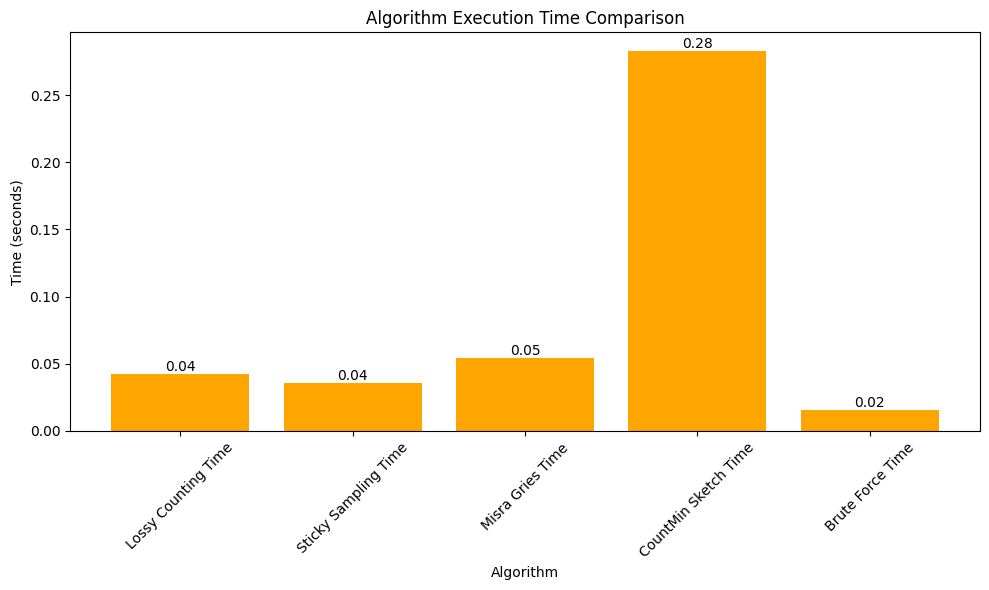

In [104]:

times = [lc_time, ss_time, mg_time, cm_time, bt_time]
labels = ['Lossy Counting Time', 'Sticky Sampling Time', 'Misra Gries Time', 'CountMin Sketch Time', 'Brute Force Time']
plt.figure(figsize=(10, 6))
plt.bar(labels, times, color='orange')
plt.title('Algorithm Execution Time Comparison')
plt.xlabel('Algorithm')
plt.ylabel('Time (seconds)')
for i in range(len(times)):
    plt.text(i, times[i], f'{times[i]:.2f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Algorithm Execution Space Comparison

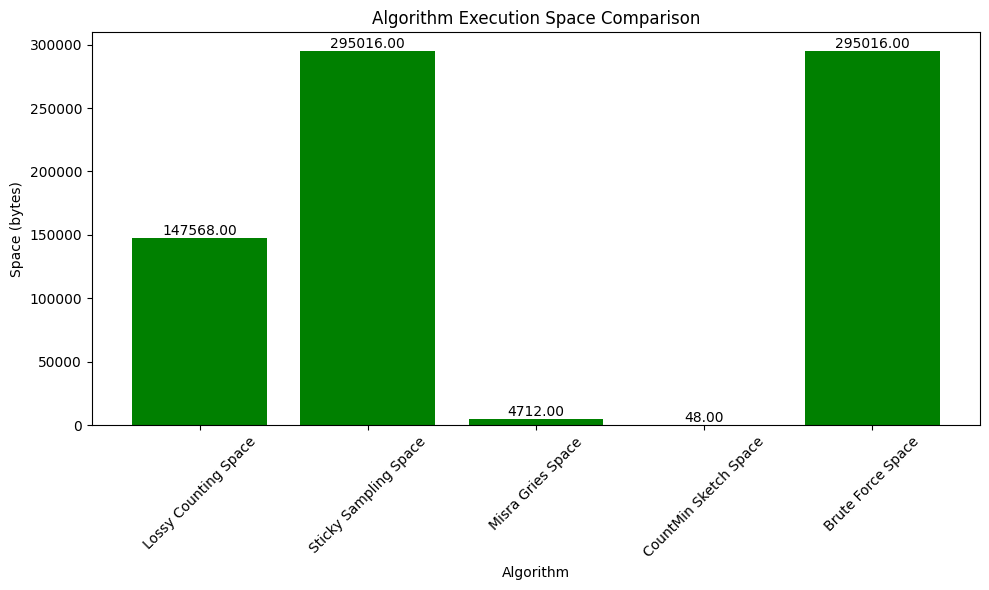

In [105]:
times = [lc_space, ss_space, mg_space, cm_space, bt_space]
labels = ['Lossy Counting Space', 'Sticky Sampling Space', 'Misra Gries Space', 'CountMin Sketch Space', 'Brute Force Space']
plt.figure(figsize=(10, 6))
plt.bar(labels, times, color='green')
plt.title('Algorithm Execution Space Comparison')
plt.xlabel('Algorithm')
plt.ylabel('Space (bytes)')
for i in range(len(times)):
    plt.text(i, times[i], f'{times[i]:.2f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Algorithm Accuracy Comparison

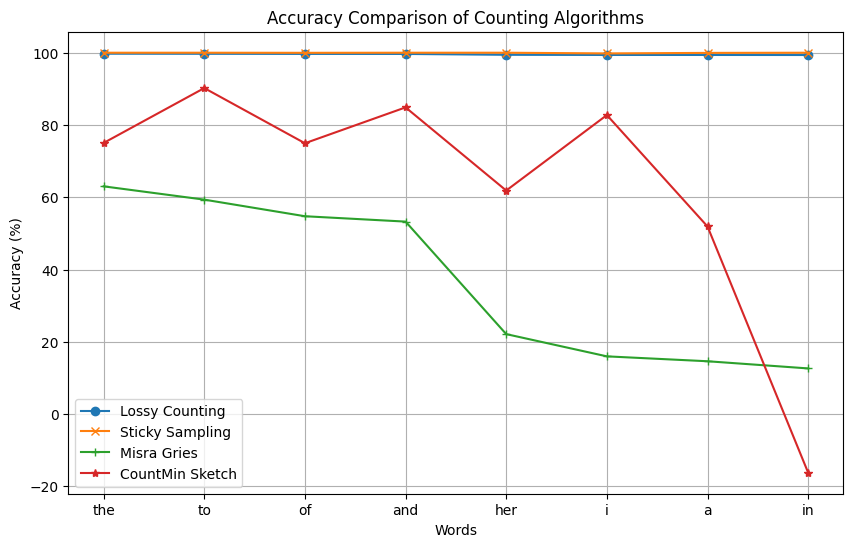

In [110]:

words = ['the', 'to', 'of', 'and', 'her', 'i', 'a', 'in']

bf_results = dict(bt_result.most_common(no_common))

def calculate_accuracy(algorithm_results):
    accuracies = []
    for word in words:
        bf_count = bf_results[word]
        algo_count = algorithm_results.get(word, 0)
        accuracy = (abs(algo_count - bf_count) / bf_count) * 100
        accuracies.append(100 - accuracy) 
    return accuracies


lc_accuracy = calculate_accuracy(lc_result)
ss_accuracy = calculate_accuracy(ss_result)
mg_accuracy = calculate_accuracy(dict(mg_result.most_common(no_common)))
cm_accuracy = calculate_accuracy(cm_result)

plt.figure(figsize=(10, 6))
plt.plot(words, lc_accuracy, label='Lossy Counting', marker='o')
plt.plot(words, ss_accuracy, label='Sticky Sampling', marker='x')
plt.plot(words, mg_accuracy, label='Misra Gries', marker='+')
plt.plot(words, cm_accuracy, label='CountMin Sketch', marker='*')

plt.title('Accuracy Comparison of Counting Algorithms')
plt.xlabel('Words')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.show()


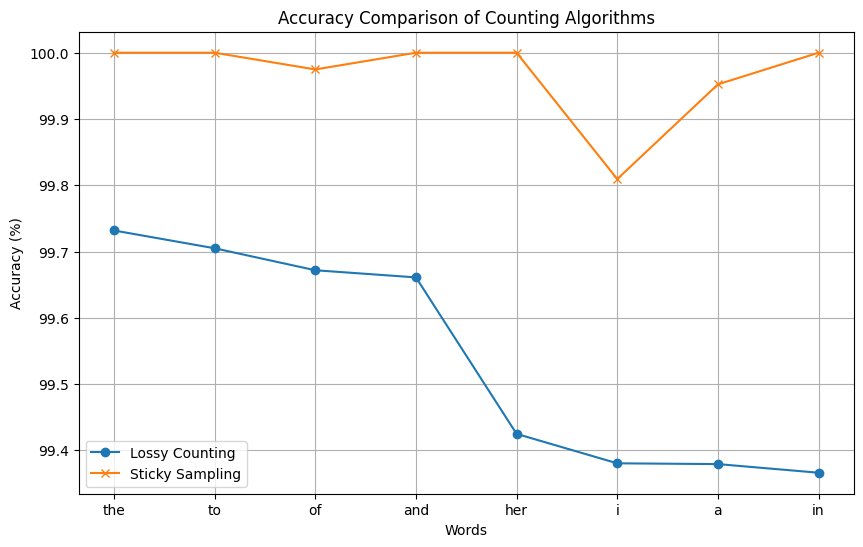

In [111]:
plt.figure(figsize=(10, 6))
plt.plot(words, lc_accuracy, label='Lossy Counting', marker='o')
plt.plot(words, ss_accuracy, label='Sticky Sampling', marker='x')


# 添加图表元素
plt.title('Accuracy Comparison of Counting Algorithms')
plt.xlabel('Words')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# 显示图表
plt.show()